## **Gold**

In [208]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import time
import warnings
warnings.filterwarnings('ignore')

## **Cargar Datos**

In [173]:
month='https://raw.githubusercontent.com/Saul-Ochoa/Time-Series/refs/heads/main/Forecasting/stocks-shares/Data/monthly_csv.csv'
year='https://raw.githubusercontent.com/Saul-Ochoa/Time-Series/refs/heads/main/Forecasting/stocks-shares/Data/annual_csv.csv'

df_month=pd.read_csv(month,sep=',')
df_year=pd.read_csv(year,sep=',')

In [174]:
df_month.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [175]:
df_month['Date']=pd.to_datetime(df_month['Date'],format='%Y-%m')
df_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    847 non-null    datetime64[ns]
 1   Price   847 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.4 KB


In [176]:
df_year['Date']=pd.to_datetime(df_year['Date'],format='%Y-%m')
df_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    70 non-null     datetime64[ns]
 1   Price   70 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.2 KB


In [177]:
print(df_year.shape)
print(df_month.shape)

(70, 2)
(847, 2)


## **EDA**

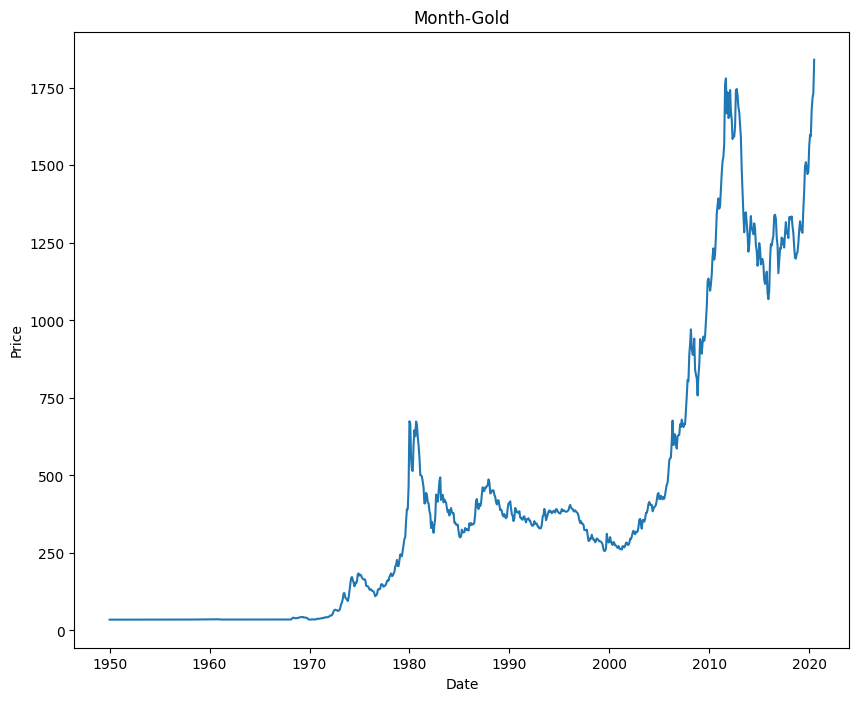

In [178]:
plt.figure(figsize=(10,8))
sns.lineplot(data=df_month,x='Date',y='Price')
plt.title('Month-Gold')
plt.show()

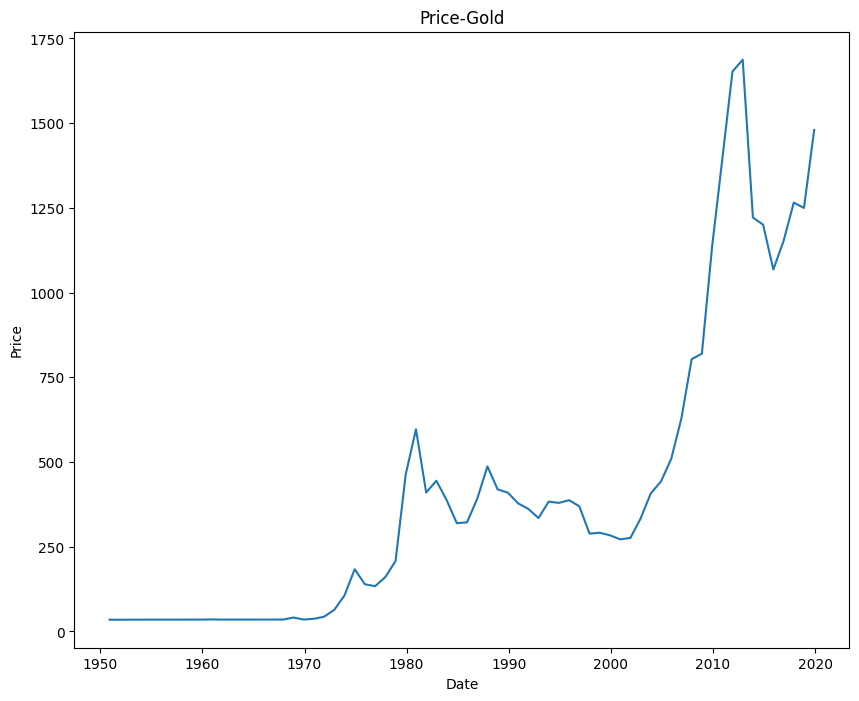

In [179]:
plt.figure(figsize=(10,8))
sns.lineplot(data=df_year,x='Date',y='Price')
plt.title('Price-Gold')
plt.show()

In [180]:
df_month['Month']=df_month['Date'].dt.month
df_month['Year']=df_month['Date'].dt.year

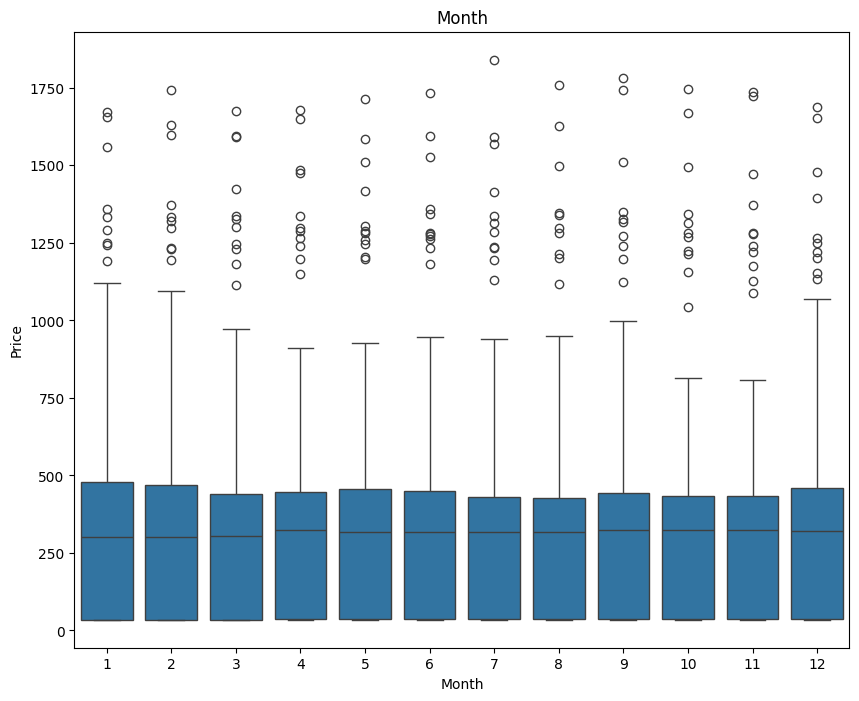

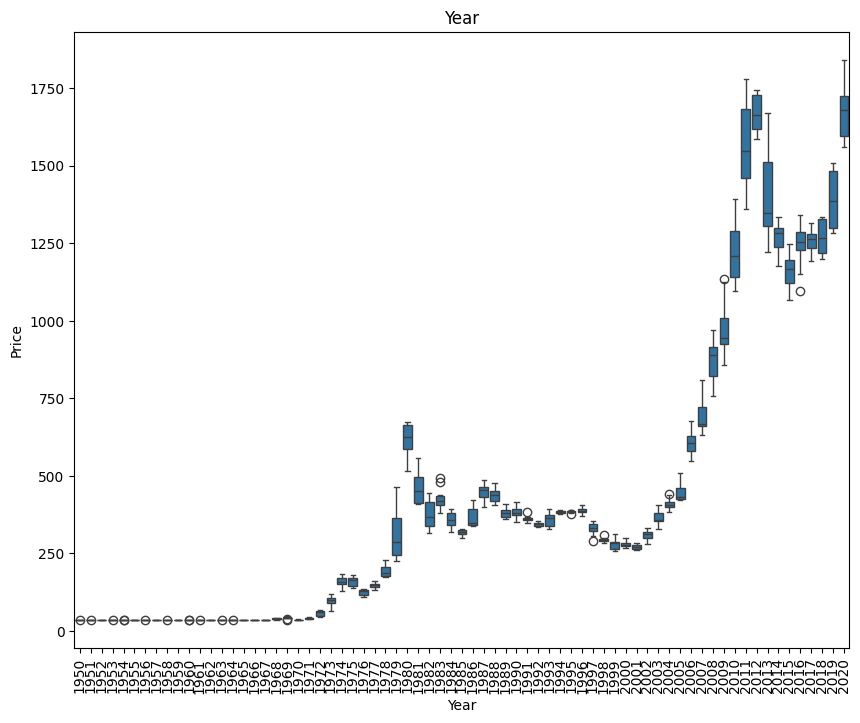

In [181]:
plt.figure(figsize=(10,8))
sns.boxplot(data=df_month,y='Price',x='Month')
plt.title('Month')
plt.show()

plt.figure(figsize=(10,8))
sns.boxplot(data=df_month,y='Price',x='Year')
plt.title('Year')
plt.xticks(rotation='vertical')
plt.show()

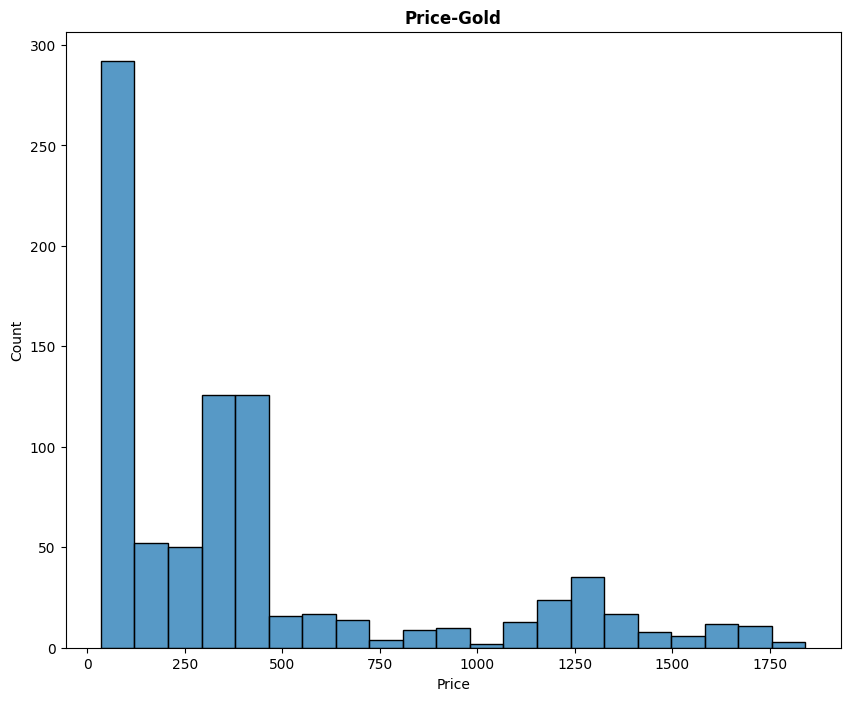

In [182]:
plt.figure(figsize=(10,8))
sns.histplot(data=df_month,x='Price')
plt.title('Price-Gold',fontsize=12,weight='bold')
plt.show()

<Figure size 1000x800 with 0 Axes>

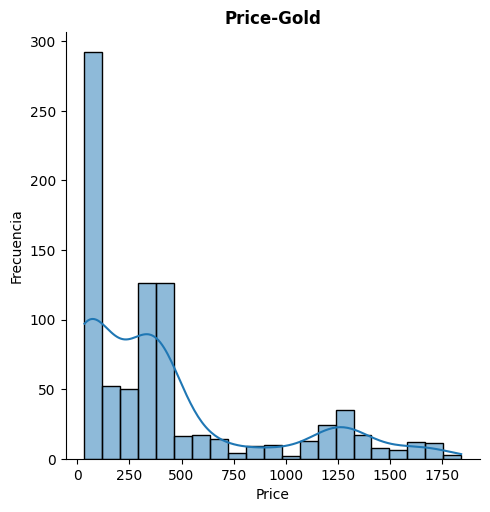

In [183]:
plt.figure(figsize=(10,8))
sns.displot(data=df_month,x='Price',kde=True)
plt.title('Price-Gold',fontsize=12,weight='bold')
plt.ylabel('Frecuencia')
plt.show()

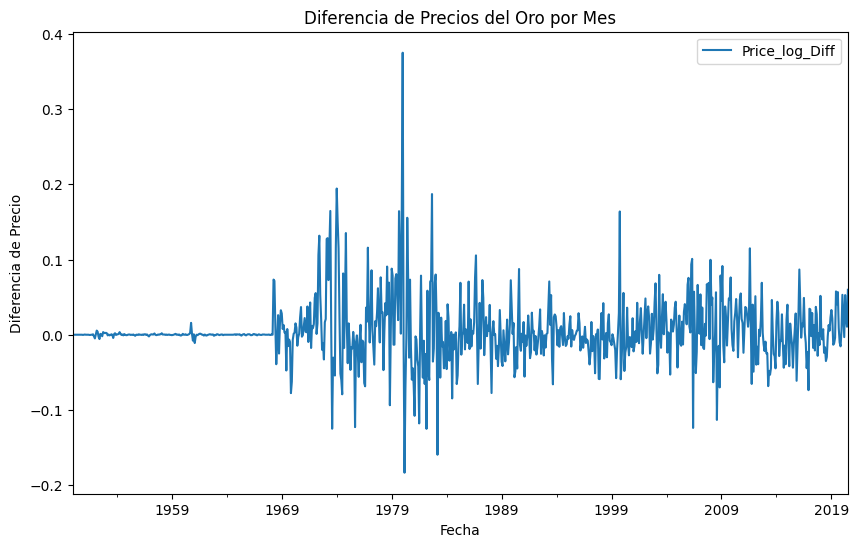

In [184]:
# Graficos por diferencia
df_month['Price_log']=df_month['Price'].apply(np.log)
df_month['Price_log_Diff']=df_month['Price_log'].diff()
df_month.plot(x='Date', y='Price_log_Diff', title='Diferencia de Precios del Oro por Mes', xlabel='Fecha', ylabel='Diferencia de Precio', figsize=(10,6))
plt.show()

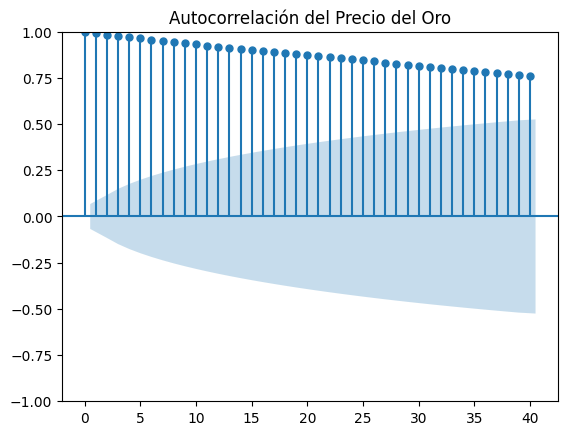

In [185]:
plot_acf(df_month['Price'], lags=40)
plt.title('Autocorrelación del Precio del Oro')
plt.show()

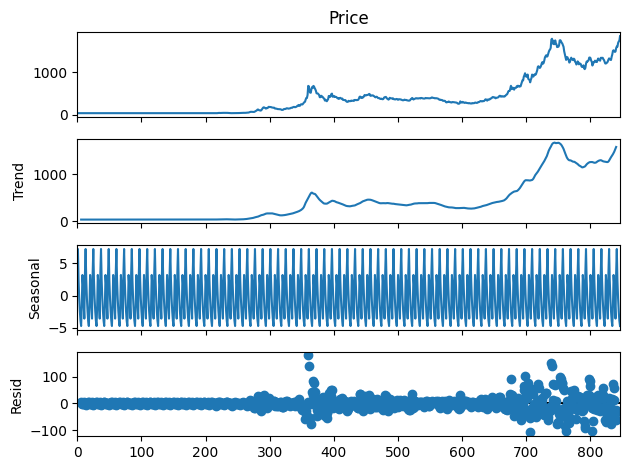

In [186]:
decomposition = seasonal_decompose(df_month['Price'], model='additive', period=12)
decomposition.plot()
plt.show()

## **Preparación de los datos**

In [187]:
def check_stationarity(dataframe, column):
    """
    Verifica la estacionariedad de una serie temporal usando pruebas ADF y KPSS.
    
    Parameters:
    dataframe: pd.DataFrame - DataFrame que contiene la serie temporal.
    column: str - Nombre de la columna que se analizará.
    
    Returns:
    None
    """
    # Prueba de Dickey-Fuller Aumentado (ADF)
    adf_result = adfuller(dataframe[column])
    adf_stat = adf_result[0].round(2)
    adf_pvalue = adf_result[1].round(2)

    # Prueba KPSS
    kpss_result = kpss(dataframe[column])
    kpss_stat = kpss_result[0].round(2)
    kpss_pvalue = kpss_result[1].round(2)

    # Imprimir resultados
    print(f'Estadístico ADF: {adf_stat}')
    print(f'p-value ADF: {adf_pvalue}')
    print(f'Estadístico KPSS: {kpss_stat}')
    print(f'p-value KPSS: {kpss_pvalue}')

    # Condicional para determinar estacionariedad
    if adf_pvalue < 0.05:
        print("La serie es estacionaria según la prueba de Dickey-Fuller (ADF).")
    else:
        print("La serie NO es estacionaria según la prueba de Dickey-Fuller (ADF).")

    if kpss_pvalue < 0.05:
        print("La serie NO es estacionaria según la prueba KPSS.")
    else:
        print("La serie es estacionaria según la prueba KPSS.")

# Uso de la función
check_stationarity(df_month, 'Price')

Estadístico ADF: 0.81
p-value ADF: 0.99
Estadístico KPSS: 3.27
p-value KPSS: 0.01
La serie NO es estacionaria según la prueba de Dickey-Fuller (ADF).
La serie NO es estacionaria según la prueba KPSS.


In [188]:
# Eliminar filas con valores nulos en 'Price_Diff'
df_month.dropna(subset=['Price_log_Diff'], axis=0, inplace=True)

In [189]:
df_month.columns

Index(['Date', 'Price', 'Month', 'Year', 'Price_log', 'Price_log_Diff'], dtype='object')

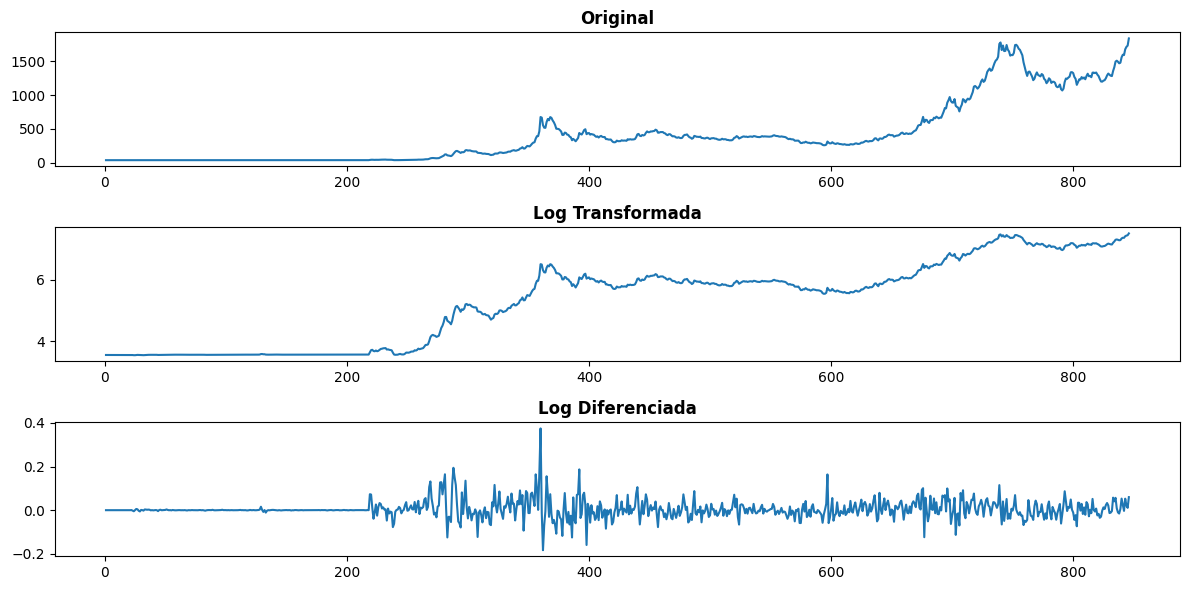

In [190]:
# Visualizar los datos originales y transformados
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(df_month.index, df_month['Price'], label='Original')
plt.title('Original',fontsize=12,weight='bold')

plt.subplot(3, 1, 2)
plt.plot(df_month.index, df_month['Price_log'], label='Log Transformada')
plt.title('Log Transformada',fontsize=12,weight='bold')

plt.subplot(3, 1, 3)
plt.plot(df_month.index, df_month['Price_log_Diff'], label='Log Diferenciada')
plt.title('Log Diferenciada',fontsize=12,weight='bold')

plt.tight_layout()
plt.show()

In [191]:
# Uso de la función
check_stationarity(df_month, 'Price_log')
# Uso de la función
check_stationarity(df_month, 'Price_log_Diff')

Estadístico ADF: -0.42
p-value ADF: 0.91
Estadístico KPSS: 4.06
p-value KPSS: 0.01
La serie NO es estacionaria según la prueba de Dickey-Fuller (ADF).
La serie NO es estacionaria según la prueba KPSS.
Estadístico ADF: -5.87
p-value ADF: 0.0
Estadístico KPSS: 0.13
p-value KPSS: 0.1
La serie es estacionaria según la prueba de Dickey-Fuller (ADF).
La serie es estacionaria según la prueba KPSS.


In [192]:
df_month.columns

Index(['Date', 'Price', 'Month', 'Year', 'Price_log', 'Price_log_Diff'], dtype='object')

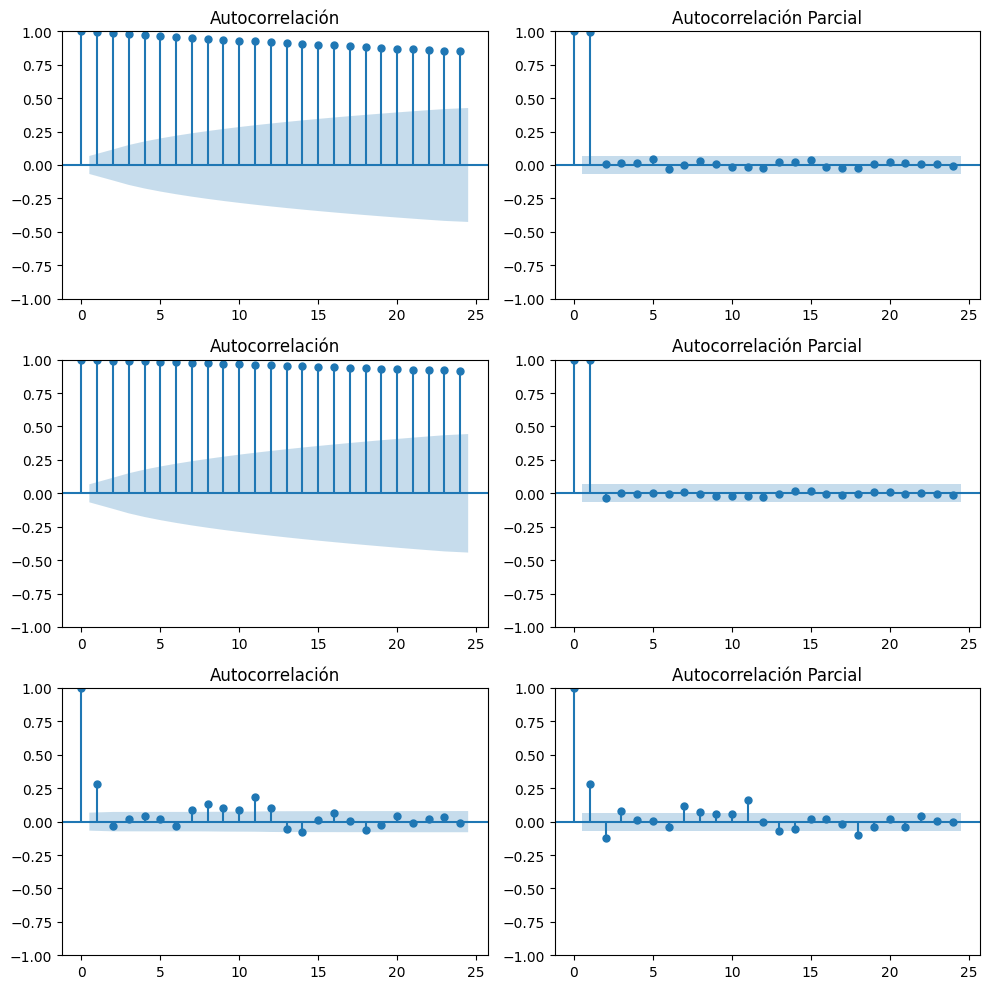

In [193]:
LAGS = 24

fig = plt.figure(figsize = (10, 10))

((ax1, ax2), (ax3, ax4), (ax5, ax6)) = fig.subplots(3, 2)

# ----------------------------------------------------------------------------------------------------
# plot the data using the built in plots from the stats module
plot_acf(df_month['Price'], ax = ax1, lags = LAGS, title = "Autocorrelación")
plot_pacf(df_month['Price'], ax = ax2, lags = LAGS, title = "Autocorrelación Parcial")

plot_acf(df_month['Price_log'], ax = ax3, lags = LAGS, title = "Autocorrelación")
plot_pacf(df_month['Price_log'], ax = ax4, lags = LAGS, title = "Autocorrelación Parcial")

plot_acf(df_month['Price_log_Diff'], ax = ax5, lags = LAGS, title = "Autocorrelación")
plot_pacf(df_month['Price_log_Diff'], ax = ax6, lags = LAGS, title = "Autocorrelación Parcial")

fig.tight_layout()

## **Modelo de Series de Tiempos**

In [194]:
df_new=df_month[['Date','Price_log_Diff']]
df_new.set_index('Date',inplace=True)
df_new.head()

,Price_log_Diff
Date,
1950-02-01,0.0
1950-03-01,0.0
1950-04-01,0.0
1950-05-01,0.0
1950-06-01,0.0


In [195]:
df_new.shape

(846, 1)

In [196]:
test_size=100
train_data=df_new[:-test_size].dropna()
test_data=df_new[-test_size:].dropna()
test=test_data.copy()

In [197]:
train_data.columns

Index(['Price_log_Diff'], dtype='object')

In [212]:
# Elegir p y q basándote en las gráficas (ejemplo: p=1, q=1)
p = 2
d = 1
q = 1

# Parámetros estacionales
P = 2  # Componente AR estacional
D = 1  # Diferenciación estacional
Q = 2  # Componente MA estacional
m = 12  # Número de períodos en un ciclo completo de estacionalidad (mensual, en este caso 12)


# Ajustar el modelo SARIMAX
model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, m))
model_fit = model.fit(disp=False)

# Resumen del modelo
print(model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                          Price_log_Diff   No. Observations:                  746
Model:             SARIMAX(2, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                1292.970
Date:                                 Mon, 14 Oct 2024   AIC                          -2569.940
Time:                                         19:16:04   BIC                          -2533.163
Sample:                                     02-01-1950   HQIC                         -2555.754
                                          - 03-01-2012                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2933      0.021     13.989      0.000       0.252       0

In [213]:
# Realizar predicciones
n_periods = len(test)  # Número de pasos a predecir igual a la longitud del conjunto de prueba
forecast = model_fit.forecast(steps=n_periods)

# Evaluar el modelo
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'RMSE: {rmse:.2f}')

RMSE: 0.03


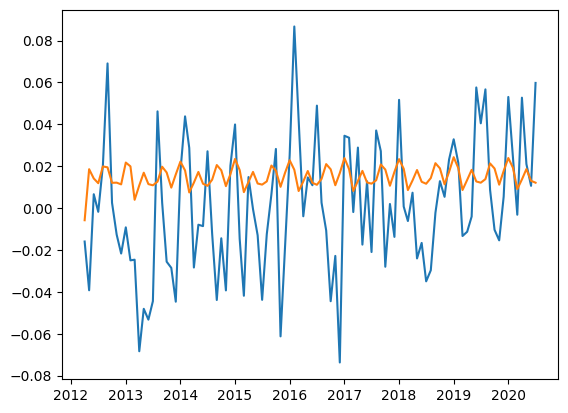

In [214]:
plt.plot(test)
plt.plot(forecast)
plt.show()